In [1]:
# For network processing
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import argparse

# For system operation
import os
import io
import random
import datetime
import time
import glob
from tqdm import tqdm

# For image processing
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

# For data augmentation
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from albumentations import *

# For data processing
import wandb
from collections import defaultdict, deque

!pip install -q torchprofile
from torchprofile import profile_macs

In [2]:
def seed_everything(seed):
    # Set Python random seed
    random.seed(seed)
    
    # Set NumPy random seed
    np.random.seed(seed)
    
    # Set PyTorch random seed for CPU and GPU
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    
    # Set PyTorch deterministic operations for cudnn backend
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [3]:
def print_with_timestamp():
    """
    This function add timestamp to each log info
    """
    import builtins as __builtin__
    builtin_print = __builtin__.print

    def print(*args, **kwargs):
        timestamp = datetime.datetime.now().strftime("[%H:%M:%S]")
        args = (f"{timestamp} ",) + args
        builtin_print(*args, **kwargs)

    __builtin__.print = print

In [4]:
def rle_encode(x, fg_val=1):
    """
    Args:
        x:  numpy array of shape (height, width), 1 - mask, 0 - background
        fg_val: Value representing the foreground in the input array (default is 1)
    Returns: run length encoding as list
    """
    # Find indices where the array is equal to the foreground value
    dots = np.where(x.T.flatten() == fg_val)[0]  # .T sets Fortran order down-then-right
    
    run_lengths = []
    prev = -2
    for b in dots:
        # If the index is not consecutive, start a new run
        if b > prev + 1:
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1  # Increment the length of the current run
        prev = b

    return run_lengths

def list_to_string(x):
    """
    Converts list to a string representation
    Empty list returns '-'
    """
    if x:  # Check if the list is non-empty
        s = str(x).replace("[", "").replace("]", "").replace(",", "")
    else:
        s = '-'
    return s

def rle_decode(mask_rle, shape=(566, 640)):
    '''
    mask_rle: run-length as string formatted (start length)
              empty predictions need to be encoded with '-'
    shape: (height, width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    # Initialize an array of zeros with the specified shape
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    
    # Check if the mask_rle is empty
    if mask_rle != '-': 
        s = mask_rle.split()
        # Extract start and length information from the string
        starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
        starts -= 1  # Convert to 0-based indexing
        ends = starts + lengths
        
        # Set the corresponding indices to 1 in the array
        for lo, hi in zip(starts, ends):
            img[lo:hi] = 1

    # Reshape the array to the specified shape and return
    return img.reshape(shape, order='F')  # Needed to align to RLE direction

In [5]:
class WandbLogger(object):
    
    def __init__(self, config):
        
        self.config = config
        self._wandb =  wandb
        
    def login(self, key):
        self._wandb.login(key=key, relogin=True)
        
    def init_run(self):
        self.mask_table = wandb.Table(columns=["Images", "Masks", "Probs", "Preds", "Fusion", "IoU"], allow_mixed_types=True)
        self._wandb.init(
            config=self.config,
            project=self.config["project"],
            entity=self.config["entity"],
            name=self.config["name"],
            reinit=True
        )

    def log_checkpoints(self):
        output_dir = self.config["output_dir"]
        model_artifact = self._wandb.Artifact(
            self._wandb.run.id + "_model", type="model"
        )

        model_artifact.add_dir(output_dir)
        self._wandb.log_artifact(model_artifact, aliases=["latest", "best"])
        
    def log_image(self, images, masks, probs, binary_mask_threshold, fusion, iou):
        self.mask_table.add_data(
            wandb.Image(images),
            wandb.Image(masks),
            wandb.Image(probs),
            wandb.Image(binary_mask_threshold),
            wandb.Image(fusion),
            iou
        )

In [6]:
class SmoothedValue(object):
    """Track a series of values and provide access to smoothed values over a
    window or the global series average.
    """

    def __init__(self, window_size=20, fmt=None):
        if fmt is None:
            fmt = "{value:.4f} ({global_avg:.4f})"
        self.deque = deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        self.fmt = fmt

    def update(self, value, n=1):
        self.deque.append(value)
        self.count += n
        self.total += value * n

    def synchronize_between_processes(self):
        """
        Warning: does not synchronize the deque!
        """
        if not is_dist_avail_and_initialized():
            return
        t = torch.tensor([self.count, self.total], dtype=torch.float64, device='cuda')
        dist.barrier()
        dist.all_reduce(t)
        t = t.tolist()
        self.count = int(t[0])
        self.total = t[1]

    @property
    def median(self):
        d = torch.tensor(list(self.deque))
        return d.median().item()

    @property
    def avg(self):
        d = torch.tensor(list(self.deque), dtype=torch.float32)
        return d.mean().item()

    @property
    def global_avg(self):
        return self.total / self.count

    @property
    def max(self):
        return max(self.deque)

    @property
    def value(self):
        return self.deque[-1]

    def __str__(self):
        return self.fmt.format(
            median=self.median,
            avg=self.avg,
            global_avg=self.global_avg,
            max=self.max,
            value=self.value)

In [7]:
class MetricLogger(object):
    def __init__(self, delimiter="\t"):
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if isinstance(v, torch.Tensor):
                v = v.item()
            assert isinstance(v, (float, int))
            self.meters[k].update(v)

    def __getattr__(self, attr):
        if attr in self.meters:
            return self.meters[attr]
        if attr in self.__dict__:
            return self.__dict__[attr]
        raise AttributeError("'{}' object has no attribute '{}'".format(
            type(self).__name__, attr))

    def __str__(self):
        loss_str = []
        for name, meter in self.meters.items():
            loss_str.append(
                "{}: {}".format(name, str(meter))
            )
        return self.delimiter.join(loss_str)

    def synchronize_between_processes(self):
        for meter in self.meters.values():
            meter.synchronize_between_processes()

    def add_meter(self, name, meter):
        self.meters[name] = meter

    def log_every(self, iterable, print_freq, header=None):
        i = 0
        if not header:
            header = ''
        start_time = time.time()
        end = time.time()
        iter_time = SmoothedValue(fmt='{avg:.4f}')
        data_time = SmoothedValue(fmt='{avg:.4f}')
        space_fmt = ':' + str(len(str(len(iterable)))) + 'd'
        if torch.cuda.is_available():
            log_msg = self.delimiter.join([
                header,
                '[{0' + space_fmt + '}/{1}]',
                'eta: {eta}',
                '{meters}',
                'time: {time}',
                'data: {data}',
                'max mem: {memory:.0f}'
            ])
        else:
            log_msg = self.delimiter.join([
                header,
                '[{0' + space_fmt + '}/{1}]',
                'eta: {eta}',
                '{meters}',
                'time: {time}',
                'data: {data}'
            ])
        MB = 1024.0 * 1024.0
        for obj in iterable:
            data_time.update(time.time() - end)
            yield obj
            iter_time.update(time.time() - end)
            if i % print_freq == 0:
                eta_seconds = iter_time.global_avg * (len(iterable) - i)
                eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
                if torch.cuda.is_available():
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time),
                        memory=torch.cuda.max_memory_allocated() / MB))
                else:
                    print(log_msg.format(
                        i, len(iterable), eta=eta_string,
                        meters=str(self),
                        time=str(iter_time), data=str(data_time)))
            i += 1
            end = time.time()
        total_time = time.time() - start_time
        total_time_str = str(datetime.timedelta(seconds=int(total_time)))
        print('{} Total time: {}'.format(header, total_time_str))

In [8]:
def build_transform(is_train, args):
    """
    Create a data transformation pipeline for image processing in deep learning tasks.
    """
    t = []
    if is_train:
        t.append(A.Resize(args.input_size[-2], args.input_size[-1]))
        #t.append(A.Rotate(limit=10, p=0.5))  # 隨機旋轉
        #t.append(A.HorizontalFlip(p=0.5))    # 隨機水平翻轉
        #t.append(A.RandomCrop(height=args.input_size[-2] - 20, width=args.input_size[-1] - 20, p=0.5))  # 隨機裁剪
        #t.append(A.GaussNoise(var_limit=(10.0, 50.0), p=0.3))  # 高斯噪聲
        t.append(A.Normalize(args.mean, args.std))
        t.append(ToTensorV2())
        return A.Compose(t)

    t.append(A.Resize(args.input_size[-2], args.input_size[-1]))
    t.append(A.Normalize(args.mean, args.std))
    t.append(ToTensorV2())
    return A.Compose(t)

In [9]:
class DeepMedical(torch.utils.data.Dataset):
    def __init__(self, images, transforms = None):
        self.transforms = transforms   
        
        self.image_paths = images
        self.mask_paths = [image.replace('pre', 'post') + '_ROI.bmp' for image in images]

        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        
        image = np.array(Image.open(image_path).convert('RGB'))
        mask = np.array(Image.open(mask_path)) * 1

        if self.transforms:
            transformed = self.transforms(image=image, mask=mask)
            image, mask = transformed['image'], transformed['mask']
            
        return image, mask
    
class SonoDataset(torch.utils.data.Dataset):

    def __init__(self, dataset, indices):
        self.dataset = dataset
        self.indices = indices

    def __getitem__(self, idx):
        return self.dataset[self.indices[idx]]

    def __len__(self):
        return len(self.indices)

Image shape: torch.Size([16, 3, 448, 448]), mask shape torch.Size([448, 448])


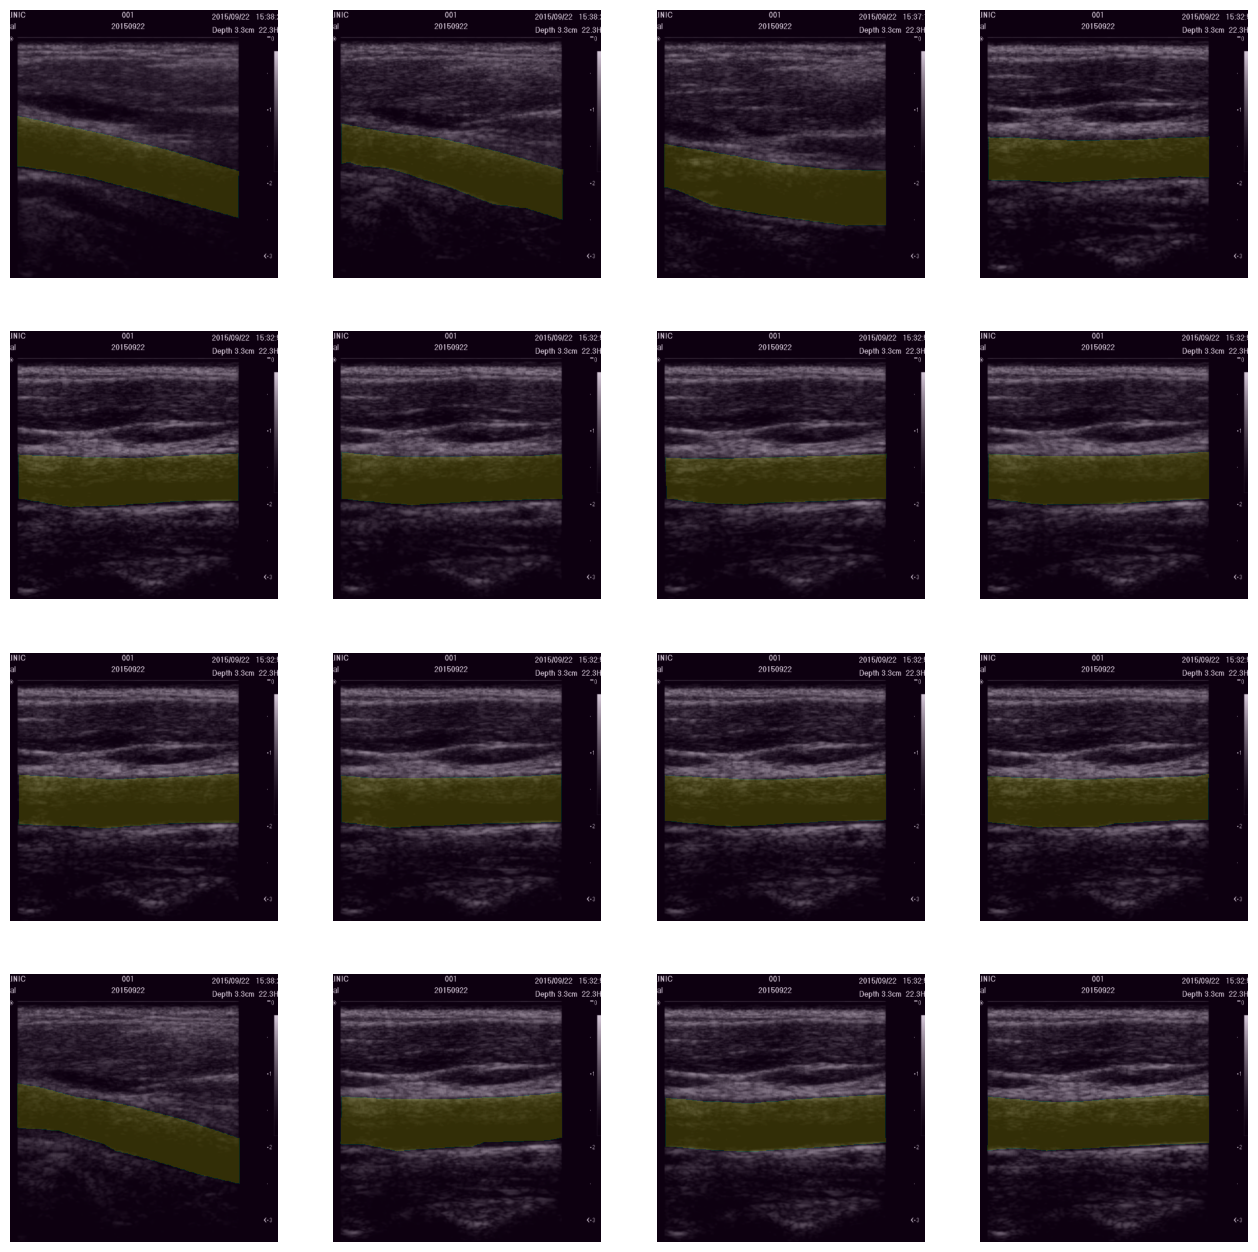

In [10]:
class config:
    
    input_size = (8, 3, 448, 448)
    mean = IMAGENET_DEFAULT_MEAN 
    std = IMAGENET_DEFAULT_STD

img_files = glob.glob(r"C:\Users\User\Desktop\Data4\hwk04_data\hwk04_data\train\pre\*")
ds = DeepMedical(images=img_files, transforms=build_transform(True, config))
dl = torch.utils.data.DataLoader(ds,batch_size=16,shuffle=False,num_workers=0)

plt.figure(figsize=(16,16))
imgs,masks = next(iter(dl))

for i,(img,mask) in enumerate(zip(imgs,masks)):
    img = ((img.permute(1,2,0)*torch.tensor(config.std) + torch.tensor(config.mean))*255.0).numpy().astype(np.uint8)
        
    plt.subplot(4,4,i+1)
    plt.imshow(img,vmin=0,vmax=255)
    plt.imshow(mask.squeeze().numpy(), alpha=0.2)
    plt.axis('off')
    plt.subplots_adjust(wspace=None, hspace=None)
        
print(f"Image shape: {imgs.shape}, mask shape {mask.shape}")
    
del ds,dl,imgs,masks

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=2):
        super(UNet, self).__init__()
        
        def double_conv(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            )
        
        self.down1 = double_conv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = double_conv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = double_conv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.down4 = double_conv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        
        self.bottleneck = double_conv(512, 1024)
        
        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv4 = double_conv(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv3 = double_conv(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv2 = double_conv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv1 = double_conv(128, 64)
        
        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        d1 = self.down1(x)
        p1 = self.pool1(d1)
        d2 = self.down2(p1)
        p2 = self.pool2(d2)
        d3 = self.down3(p2)
        p3 = self.pool3(d3)
        d4 = self.down4(p3)
        p4 = self.pool4(d4)
        
        bottleneck = self.bottleneck(p4)
        
        up4 = self.up4(bottleneck)
        merge4 = torch.cat([up4, d4], dim=1)
        c4 = self.conv4(merge4)
        up3 = self.up3(c4)
        merge3 = torch.cat([up3, d3], dim=1)
        c3 = self.conv3(merge3)
        up2 = self.up2(c3)
        merge2 = torch.cat([up2, d2], dim=1)
        c2 = self.conv2(merge2)
        up1 = self.up1(c2)
        merge1 = torch.cat([up1, d1], dim=1)
        c1 = self.conv1(merge1)
        
        output = self.final(c1)
        return output


if __name__ == "__main__":
    model = UNet(in_channels=3, out_channels=2)
    x = torch.randn((1, 3, 448, 448))
    y = model(x)
    print(y.shape)  # Should be [1, 2, 448, 448]


torch.Size([1, 2, 448, 448])


In [12]:
model = UNet()
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of parameters: {total_params}")

Total number of parameters: 31043586


In [13]:
class ConfusionMatrix(object):
    """
    update: use to update the confusion matrix in sample-wise
        a: ground truths
        b: predictions
    
    The (i, j) terms of the matrix represents class-i pixels classify to class-j
    """
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.mat = None

    def update(self, a, b):
        n = self.num_classes
        if self.mat is None:
            self.mat = torch.zeros((n, n), dtype=torch.int64, device=a.device)
        with torch.no_grad():
            k = (a >= 0) & (a < n)
            inds = n * a[k].to(torch.int64) + b[k]
            self.mat += torch.bincount(inds, minlength=n**2).reshape(n, n)

    def reset(self):
        if self.mat is not None:
            self.mat.zero_()

    def compute(self):
        h = self.mat.float()
        correct = torch.diag(h)
        acc_global = correct.sum() / h.sum()
        acc = correct / h.sum(1)
        dice = 2 * correct  / (h.sum(1) + h.sum(0))
        iou = correct / (h.sum(1) + h.sum(0) - correct)
        
        self.acc_global = acc_global
        self.acc = acc
        self.iou = iou
        self.dice = dice
        
        return acc_global, acc, iou, dice

    def reduce_from_all_processes(self):
        if not torch.distributed.is_available():
            return
        if not torch.distributed.is_initialized():
            return
        torch.distributed.barrier()
        torch.distributed.all_reduce(self.mat)

    def __str__(self):
        acc_global, acc, iou, dice = self.compute()
        self.acc_global = acc_global
        self.miou = iou.mean().item() * 100
        self.dice = dice.mean().item() * 100
        return (
            'global correct: {:.2f}\n'
            'average row correct: {}\n'
            'IoU: {} mean IoU: {:.2f}\n'
            'dice: {} mean Dice: {:.2f}\n').format(
                acc_global.item() * 100,
                ['{:.1f}'.format(i) for i in (acc * 100).tolist()],
                ['{:.1f}'.format(i) for i in (iou * 100).tolist()],
                iou.mean().item() * 100,
                ['{:.2f}'.format(i) for i in (dice * 100).tolist()],
                dice.mean().item() * 100,
            )

class intersection_over_union:
    
    def __init__(self, y_true, y_pred):
    
        union = np.count_nonzero(y_true + y_pred)
        intersection = np.count_nonzero(y_true * y_pred)
        try:
            IoU = intersection / union
        except:
            IoU = 0
        self.IoU = IoU
        self.union = (y_true + y_pred != 0) * 1
        self.intersection = (y_true * y_pred != 0) * 1
        self.FP = (y_true == 0) * (y_pred == 1) * 1
        self.FN = (y_true == 1) * (y_pred == 0) * 1  

def visualization(model, valid_loader, args):
        
    for images, masks in valid_loader:
    
        images = images.to(device=args.device, dtype=torch.float)
        masks = masks.to(device=args.device, dtype=torch.long)

        logits = model(images)
        probs = torch.nn.functional.softmax(logits, dim=1)

        probs = probs[:,1,:,:]
        preds = (probs.permute(1,2,0) * 255).cpu().detach().numpy().astype(np.uint8)

        threshold = 0.5

        binary_mask_threshold = (probs > threshold) * 1

        masks = (masks.permute(1,2,0) * 255).cpu().numpy().astype(np.uint8)
        images = ((images.squeeze(0).permute(1,2,0).cpu().detach().numpy()*np.array(args.std)+np.array(args.mean)) * 255).astype(np.uint8)
        probs = (probs.permute(1,2,0) * 255).cpu().detach().numpy().astype(np.uint8)
        binary_mask_threshold = (binary_mask_threshold.permute(1,2,0) * 255).cpu().detach().numpy().astype(np.uint8)

        iou = intersection_over_union(masks/255.0, binary_mask_threshold/255.0)
        IoU = iou.IoU
        intersection = iou.intersection
        union = iou.union
        FP = iou.FP
        FN = iou.FN

        fusion = np.concatenate([FP*255, intersection*255, FN*255], axis=2).astype(np.uint8)
        
        yield images, masks, probs, binary_mask_threshold, fusion, IoU

In [14]:
def train_one_epoch(model, train_loader, criterion, device, epoch, optimizer, print_freq=10, num_classes=2):
    model.train()
    metric_logger = MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)
    
    confmat = ConfusionMatrix(num_classes)
    for images, masks in metric_logger.log_every(train_loader, print_freq, header):
        images = images.to(device=device, dtype=torch.float)
        masks = masks.to(device=device, dtype=torch.long)

        logits = model(images)
        loss = criterion(logits, masks)
        optimizer.zero_grad()
        loss.backward()
        
        optimizer.step()
    
        confmat.update(masks.flatten(), logits.argmax(1).flatten())
        confmat.compute()
        
        metric_logger.update(loss=loss.item())
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])
        metric_logger.update(mIoU=torch.mean(confmat.iou[1:]))
        metric_logger.update(Dice=torch.mean(confmat.dice[1:]))
            
    confmat.reduce_from_all_processes()

@torch.no_grad()
def evaluate(model, data_loader, criterion, device, print_freq=10, num_classes=2, header=None):
    model.eval()
    metric_logger = MetricLogger(delimiter="  ")
    header = header
    
    confmat = ConfusionMatrix(num_classes)
    for images, masks in metric_logger.log_every(data_loader, print_freq, header):
        images = images.to(device=device, dtype=torch.float)
        masks = masks.to(device=device, dtype=torch.long)
            
        logits = model(images)
        loss = criterion(logits, masks)

        confmat.update(masks.flatten(), logits.argmax(1).flatten())
        confmat.compute()
            
        metric_logger.update(loss=loss.item())
        metric_logger.update(mIoU=torch.mean(confmat.iou[1:]))
        metric_logger.update(Dice=torch.mean(confmat.dice[1:]))

    confmat.reduce_from_all_processes()

    return metric_logger, confmat

In [15]:
#TO DO: try to set a more fitness parameters
import os

def get_args():
    parser = argparse.ArgumentParser(description='SonoDataset Training')

    # Paths and device configuration
    parser.add_argument('--root', type=str, default=r"C:\Users\User\Desktop\Data4\hwk04_data\hwk04_data", help='Root directory of the dataset')
    parser.add_argument('--device', type=str, default="cuda" if torch.cuda.is_available() else "cpu", help='Device to use for training and evaluation')
    
    # Training parameters
    parser.add_argument('--batch_size', type=int, default=16, help='Batch size for training')  # Increased batch size for better training stability
    parser.add_argument('--weight_decay', type=float, default=1e-4, help='Weight decay for regularization')
    parser.add_argument('--epochs', type=int, default=50, help='Number of training epochs')  # Increased epochs to allow for better convergence
    parser.add_argument('--lr', type=float, default=1e-3, help='Learning rate for the optimizer')  # Set a slightly larger learning rate initially
    parser.add_argument('--num_classes', type=int, default=2, help='Number of target classes (e.g., background and vessel)')
    parser.add_argument('--seed', type=int, default=42, help='Random seed for reproducibility')

    # Model input configurations
    parser.add_argument('--in_channels', type=int, default=3, help='Number of input channels (e.g., 3 for RGB images)')
    parser.add_argument('--input_size', type=tuple, default=(8, 3, 448, 448), help='Input size of the images for the model')  # Increased input size for higher resolution images
    parser.add_argument('--target_size', type=tuple, default=(566, 640), help='Target size for resizing the images')
    parser.add_argument('--mean', type=list, default=IMAGENET_DEFAULT_MEAN, help='Mean for image normalization')
    parser.add_argument('--std', type=list, default=IMAGENET_DEFAULT_STD, help='Standard deviation for image normalization')
    
    # Logging and experiment tracking with Weights and Biases
    parser.add_argument('--project', type=str, default="MIA-HW4-3U", help='Project name for W&B logging')
    parser.add_argument('--entity', type=str, default="lin36737700-n-a", help='Entity/team name for W&B logging')
    parser.add_argument('--name', type=str, default="U-net", help='Run name for W&B logging')
    parser.add_argument('--wandb', type=bool, default=True, help='Use Weights and Biases for experiment tracking')  # Set default to True to enable logging
    parser.add_argument('--sweep', type=bool, default=True, help='Enable hyperparameter sweep using W&B')
    parser.add_argument('--sweep_counts', type=int, default=3, help='Number of hyperparameter sweep runs')  # Increased sweep count for more thorough exploration
    
    # Directory and data paths
    parser.add_argument('--output_dir', type=str, default="./output", help='Directory to save model checkpoints and logs')  # Set default output directory
    parser.add_argument('--data_path', type=str, default=r"C:\Users\User\Desktop\Data4\hwk04_data\hwk04_data\train\pre\*", help='Path to the training data')

    args, _ = parser.parse_known_args()

    # Ensure output directory exists
    if not os.path.exists(args.output_dir):
        os.makedirs(args.output_dir)

    return args

sweep_config = {
    "program": "main.py",
    "method": "random",  # Changed from bayes to random for hyperparameter tuning
    "metric": {'goal': 'maximize', 'name': 'Validation Dice'},
    "parameters": {
        "lr": {
            "values": [ 0.00005, 0.00006,0.00007]  # Added more values to allow finer learning rate adjustment
        },
        "weight_decay": {
            "values": [1e-2, 1e-3, 1e-4, 1e-5, 1e-6]  # Reduced the number of very small weight decay values to simplify tuning
        },
        "batch_size": {
            "values": [2, 4]  # Added batch size to hyperparameter sweep to find optimal balance of computation and stability
        },
        "epochs": {
            "values": [5]  # Added epochs to sweep to explore how many epochs provide best generalization
        }
    }
}


In [16]:
os.environ['WANDB_NOTEBOOK_NAME'] = 'U-net.ipynb'

In [17]:
def sweeper(wandb_logger, args):
    if wandb_logger:
        wandb_logger.init_run()
        args = wandb_logger._wandb.config

    seed_everything(args.seed)

    img_files = glob.glob(args.data_path)

    train_ids, valid_ids = train_test_split(range(len(img_files)), test_size=0.2, random_state=args.seed)
    train_transform, valid_transform = build_transform(True, args), build_transform(False, args)
    train_dataset = DeepMedical(images=img_files, transforms=train_transform)
    valid_dataset = DeepMedical(images=img_files, transforms=valid_transform)
    train_dataset = SonoDataset(train_dataset, train_ids)
    valid_dataset = SonoDataset(valid_dataset, valid_ids)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=1)

    # Replaced FCN with U-Net model
    model = UNet(in_channels=args.in_channels, out_channels=args.num_classes)
    model.to(args.device)

    if wandb_logger:
        wandb_logger._wandb.watch(model)

    params_to_optimize = [
        {"params": [p for p in model.parameters() if p.requires_grad]},
    ]
    optimizer = torch.optim.AdamW(
        params_to_optimize,
        lr=args.lr, weight_decay=args.weight_decay
    )
    criterion = nn.CrossEntropyLoss() if args.num_classes > 1 else nn.BCEWithLogitsLoss()

    n_parameters = sum(p.numel() for p in params_to_optimize[0]["params"])
    macs = profile_macs(model, torch.randn(args.input_size).to(args.device))

    print("Training augmentation:", train_transform)
    print('number of params (M): %.2f' % (n_parameters / 1.e6))
    print('model flops (G):', macs / 2 / 1.e9, 'input_size:', args.input_size)
    print("LR = %.8f" % args.lr)
    print("WD = %.8f" % args.weight_decay)
    print("Batch size = %d" % args.batch_size)
    print("Number of training epochs = %d" % args.epochs)
    print("Number of training examples = %d" % len(train_dataset))
    print("Number of training steps per epoch = %d" % (len(train_dataset) // args.batch_size))
    print("Use Cosine LR scheduler")
    print("criterion = %s" % str(criterion))

    best_dice = 0
    start_time = time.time()
    print("Start Training")
    for epoch in range(args.epochs):

        train_one_epoch(model, train_loader, criterion, args.device, epoch, optimizer)
        train_logger, train_confmat = evaluate(model, train_loader, criterion, device=args.device, num_classes=args.num_classes, print_freq=len(train_dataset), header="Eval [Train]")
        valid_logger, valid_confmat = evaluate(model, valid_loader, criterion, device=args.device, num_classes=args.num_classes, print_freq=len(valid_dataset), header="Eval [Valid]")

        if wandb_logger:
            wandb_logger._wandb.log({f"Training Loss": getattr(train_logger, "loss", -1).value})
            wandb_logger._wandb.log({f"Training mIoU": getattr(train_logger, "mIoU", -1).value})
            wandb_logger._wandb.log({f"Training Dice": getattr(train_logger, "Dice", -1).value})

            wandb_logger._wandb.log({f"Validation Loss": getattr(valid_logger, "loss", -1).value})
            wandb_logger._wandb.log({f"Validation mIoU": getattr(valid_logger, "mIoU", -1).value})
            wandb_logger._wandb.log({f"Validation Dice": getattr(valid_logger, "Dice", -1).value})

        info = str(valid_confmat)
        print(info)

        save_file = {
            "model": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "epoch": epoch,
            "args": wandb_logger.config if wandb_logger else {key: value for key, value in args.__dict__.items() if not key.startswith('__') and not callable(value)}
        }
        if valid_confmat.dice > best_dice:
            best_dice = valid_confmat.dice
            torch.save(save_file, os.path.join(args.output_dir, "best_ckpt.pth"))
            if wandb_logger:
                wandb_logger._wandb.save("best_ckpt.pth")
        torch.save(save_file, os.path.join(args.output_dir, "last_ckpt.pth"))
        if wandb_logger:
            wandb_logger._wandb.save("last_ckpt.pth")

    if wandb_logger:
        wandb_logger._wandb.log({f"Best Dice": best_dice})

    total_time = time.time() - start_time
    total_time_str = str(datetime.timedelta(seconds=int(total_time)))
    print("Training finish with time {}".format(total_time_str))

    if wandb_logger:
        print("Start logging images")
        iterator = visualization(model, valid_loader, args)
        for data in iterator:
            wandb_logger.log_image(*data)
        wandb_logger._wandb.log({"Image table": wandb_logger.mask_table})
    print("Finish")

if __name__ == '__main__':
    print_with_timestamp()

    args = get_args()
    config = {key: value for key, value in args.__dict__.items() if not key.startswith('__') and not callable(value)}

    if args.wandb:
        WANDB_API = "1d94a7cbbefd621e2e51e69a66b99192e75697f4"

        wandb_logger = WandbLogger(config)
        wandb_logger.login(WANDB_API)

        if args.sweep:
            sweep_id = wandb.sweep(sweep_config, project=args.project)
            wandb.agent(sweep_id, function=lambda: sweeper(wandb_logger, args), count=args.sweep_counts)
        else:
            sweeper(wandb_logger, args)
    else:
        sweeper(None, args)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\User\_netrc


[16:33:08]  Create sweep with ID: zwc99yxe
[16:33:08]  Sweep URL: https://wandb.ai/lin36737700-n-a/MIA-HW4-3U/sweeps/zwc99yxe


wandb: Agent Starting Run: u3oedsl0 with config:
wandb: 	batch_size: 4
wandb: 	epochs: 5
wandb: 	lr: 5e-05
wandb: 	weight_decay: 0.01
wandb: Currently logged in as: lin36737700 (lin36737700-n-a). Use `wandb login --relogin` to force relogin
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


[16:33:20]  Training augmentation: Compose([
  Resize(p=1.0, height=448, width=448, interpolation=1, mask_interpolation=0),
  Normalize(p=1.0, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, normalization='standard'),
  ToTensorV2(p=1.0, transpose_mask=False),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True)
[16:33:20]  number of params (M): 31.04
[16:33:20]  model flops (G): 669.413670912 input_size: [8, 3, 448, 448]
[16:33:20]  LR = 0.00005000
[16:33:20]  WD = 0.01000000
[16:33:20]  Batch size = 4
[16:33:20]  Number of training epochs = 5
[16:33:20]  Number of training examples = 240
[16:33:20]  Number of training steps per epoch = 60
[16:33:20]  Use Cosine LR scheduler
[16:33:20]  criterion = CrossEntropyLoss()
[16:33:20]  Start Training
[16:33:22]  Epoch: [0]  [ 0/60]  eta: 0:01:45  lr: 0.000050  loss: 0.6209 (0.6209)  mIoU: 0.0162 (0.0162)  Dice: 0.0320 (0.0320)  time: 1.7654  data: 0.1737  max mem: 8890
[

Best Dice,▁
Training Dice,▁▇███
Training Loss,█▄▃▂▁
Training mIoU,▁▇███
Validation Dice,▁████
Validation Loss,█▅▃▂▁
Validation mIoU,▁████
Best Dice,98.681
Training Dice,0.97667
Training Loss,0.09877
Training mIoU,0.95441


wandb: Agent Starting Run: nc5wlotg with config:
wandb: 	batch_size: 2
wandb: 	epochs: 5
wandb: 	lr: 7e-05
wandb: 	weight_decay: 1e-06
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


[16:41:09]  Training augmentation: Compose([
  Resize(p=1.0, height=448, width=448, interpolation=1, mask_interpolation=0),
  Normalize(p=1.0, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, normalization='standard'),
  ToTensorV2(p=1.0, transpose_mask=False),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True)
[16:41:09]  number of params (M): 31.04
[16:41:09]  model flops (G): 669.413670912 input_size: [8, 3, 448, 448]
[16:41:09]  LR = 0.00007000
[16:41:09]  WD = 0.00000100
[16:41:09]  Batch size = 2
[16:41:09]  Number of training epochs = 5
[16:41:09]  Number of training examples = 240
[16:41:09]  Number of training steps per epoch = 120
[16:41:09]  Use Cosine LR scheduler
[16:41:09]  criterion = CrossEntropyLoss()
[16:41:09]  Start Training
[16:41:17]  Epoch: [0]  [  0/120]  eta: 0:16:35  lr: 0.000070  loss: 0.6243 (0.6243)  mIoU: 0.0044 (0.0044)  Dice: 0.0088 (0.0088)  time: 8.2936  data: 0.0321  max mem: 889

Best Dice,▁
Training Dice,▁▆▇██
Training Loss,█▅▃▂▁
Training mIoU,▁▆▇██
Validation Dice,▁▆███
Validation Loss,█▅▃▂▁
Validation mIoU,▁▆███
Best Dice,98.63149
Training Dice,0.97573
Training Loss,0.05201
Training mIoU,0.95262


wandb: Agent Starting Run: 1tqneahn with config:
wandb: 	batch_size: 2
wandb: 	epochs: 5
wandb: 	lr: 7e-05
wandb: 	weight_decay: 0.001
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


[16:49:33]  Training augmentation: Compose([
  Resize(p=1.0, height=448, width=448, interpolation=1, mask_interpolation=0),
  Normalize(p=1.0, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, normalization='standard'),
  ToTensorV2(p=1.0, transpose_mask=False),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True)
[16:49:33]  number of params (M): 31.04
[16:49:33]  model flops (G): 669.413670912 input_size: [8, 3, 448, 448]
[16:49:33]  LR = 0.00007000
[16:49:33]  WD = 0.00100000
[16:49:33]  Batch size = 2
[16:49:33]  Number of training epochs = 5
[16:49:33]  Number of training examples = 240
[16:49:33]  Number of training steps per epoch = 120
[16:49:33]  Use Cosine LR scheduler
[16:49:33]  criterion = CrossEntropyLoss()
[16:49:33]  Start Training
[16:49:41]  Epoch: [0]  [  0/120]  eta: 0:16:22  lr: 0.000070  loss: 0.6243 (0.6243)  mIoU: 0.0044 (0.0044)  Dice: 0.0088 (0.0088)  time: 8.1913  data: 0.0460  max mem: 889

Best Dice,▁
Training Dice,▁▇███
Training Loss,█▄▃▂▁
Training mIoU,▁▇███
Validation Dice,▁▆███
Validation Loss,█▅▃▂▁
Validation mIoU,▁▆███
Best Dice,98.7041
Training Dice,0.97657
Training Loss,0.0518
Training mIoU,0.95421


In [18]:
import pandas as pd

class SonoInferenceDataset(torch.utils.data.Dataset):
    
    def __init__(self, root, df, transforms=None):
        
        self.root = root
        self.df = df
        self.transforms = transforms
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self,idx):
        
        image_path = os.path.join(self.root, "test", "pre", self.df.iloc[idx,0])
        
        image = np.array(Image.open(image_path).convert('RGB'))

        if self.transforms:
            transformed = self.transforms(image=image)
            image = transformed['image']
            
        return image

@torch.no_grad()
def inference(model, data_loader, args):
    model.eval()
    
    rle = []
    for images in tqdm(data_loader):
        images = images.to(device=args.device, dtype=torch.float)
            
        logits = model(images)
        masks = logits.argmax(dim=1).detach().cpu().numpy()
        for batch, mask in enumerate(masks):
            mask = Image.fromarray((mask*255).astype(np.uint8)).resize((args.target_size[1], args.target_size[0]))
            rle.append(rle_encode(np.array(mask), fg_val=255))
    return rle

In [20]:
args = get_args()
sample_submission = pd.read_csv(os.path.join(args.root, "sample_submission.csv"))
test_dataset = SonoInferenceDataset(args.root, sample_submission, build_transform(False, args))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)
state_dict = torch.load(os.path.join(args.output_dir, "best_ckpt.pth"), map_location=args.device)
model = UNet()
model.to(args.device)
model.load_state_dict(state_dict["model"])
rle = inference(model, test_loader, args)
sample_submission["rle_encode"] = [list_to_string(r) for r in rle]
sample_submission.to_csv("submission.csv", index=0)

C:\Users\User\AppData\Local\Temp\ipykernel_36280\233579033.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(os.path.join(args.output_dir, "best_ck

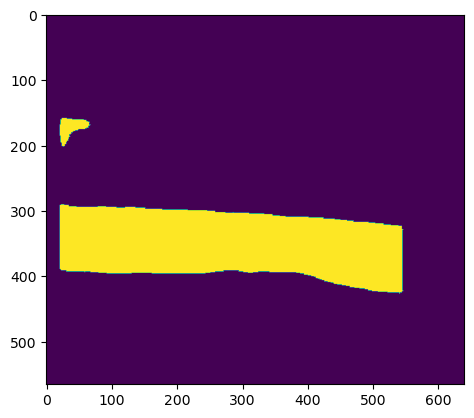

In [21]:
plt.imshow(rle_decode(list_to_string(rle[0])))